In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dogs-vs-cats.zip

Archive:  /content/drive/MyDrive/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [3]:
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [4]:
!unzip /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

**Q1. Consider the Cats & Dogs example. Start initially with a training sample of 500, a validation sample of 250, and a test sample of 250 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**








Copying images to training, validation, and test directories

In [5]:
import os, shutil, pathlib

original_di = pathlib.Path("train")
newbase_di = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = newbase_di / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_di / fname,
                            dst=dir / fname)

make_subset("train", start_index=667, end_index=1167)
make_subset("validation", start_index=1168, end_index=1418)
make_subset("test", start_index=1419, end_index=1669)

Reading pictures with "image_dataset_from_directory"

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

training_df = image_dataset_from_directory(
    newbase_di / "train",
    image_size=(180, 180),
    batch_size=32)
valid_df= image_dataset_from_directory(
    newbase_di / "validation",
    image_size=(180, 180),
    batch_size=32)
testing_df= image_dataset_from_directory(
    newbase_di / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


Construct a dataset instance using a NumPy array containing 500 random samples, with each sample having a vector size of 16

In [7]:
import numpy as np
import tensorflow as tf
random_no = np.random.normal(size=(500, 16))
data = tf.data.Dataset.from_tensor_slices(random_no)

In [8]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [9]:
batch_d = data.batch(32)
for i, element in enumerate(batch_d):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [10]:
reshape_d = data.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshape_d):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Developing the model

Creating a tiny network for categorizing dogs versus cats

In [11]:
for data_batch, labels_batch in training_df:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape=(180, 180, 3))
si = layers.Rescaling(1./255)(input)
si = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(si)
si = layers.MaxPooling2D(pool_size=2)(si)
si = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(si)
si = layers.MaxPooling2D(pool_size=2)(si)
si = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(si)
si = layers.MaxPooling2D(pool_size=2)(si)
si = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(si)
si = layers.MaxPooling2D(pool_size=2)(si)
si = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(si)
si = layers.Flatten()(si)
si = layers.Dropout(0.5)(si)
output = layers.Dense(1, activation="sigmoid")(si)
model = keras.Model(inputs=input, outputs=output)

preparing  model for training

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

We first build the model, then use the training dataset to train it. At the conclusion of each epoch, we validate the model's performance using the validation dataset. In order to shorten the execution time of each epoch, I'm using GPU.

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Dataset is used for model fitting

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callback = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_df,
    epochs=10,
    validation_data=valid_df,
    callbacks=callback)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.4926 - loss: 0.7040 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4939 - loss: 0.6933 - val_accuracy: 0.6140 - val_loss: 0.6924
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5176 - loss: 0.6921 - val_accuracy: 0.5760 - val_loss: 0.6869
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5256 - loss: 0.6899 - val_accuracy: 0.6300 - val_loss: 0.6622
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6119 - loss: 0.6652 - val_accuracy: 0.6300 - val_loss: 0.6384
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6097 - loss: 0.6488 - val_accuracy: 0.6500 - val_loss: 0.6378
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6615 - loss: 0.6228 - val_accuracy: 0.6360 - val_loss: 0.6259
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6691 - loss: 0.6002 - val_accuracy: 0.6720 

For better visualization and understanding the curves of loss and accuracy during training were constructed

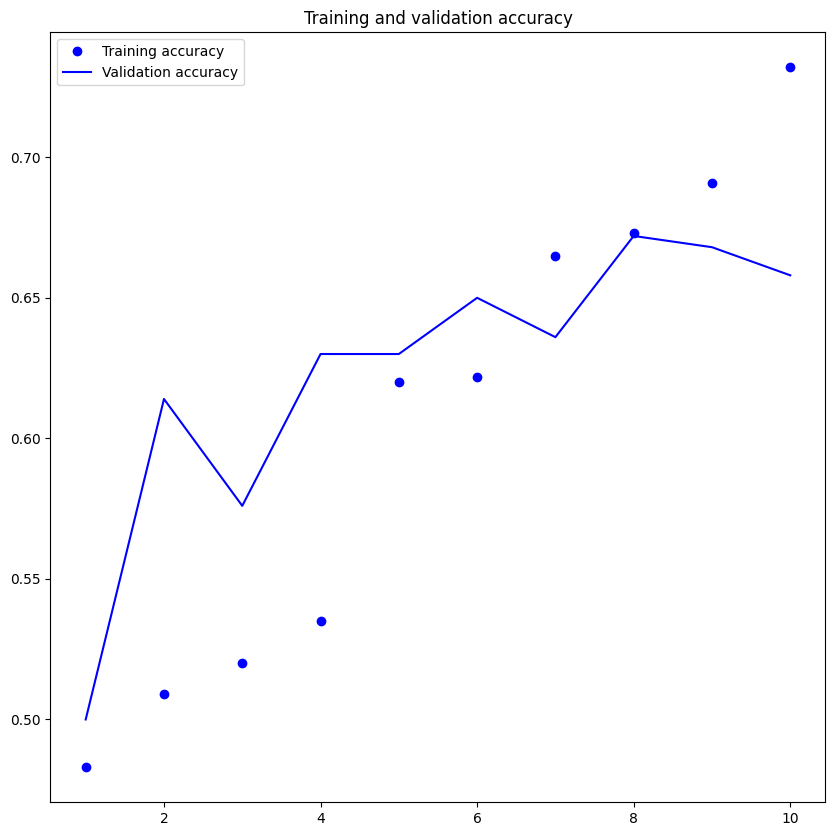

<Figure size 640x480 with 0 Axes>

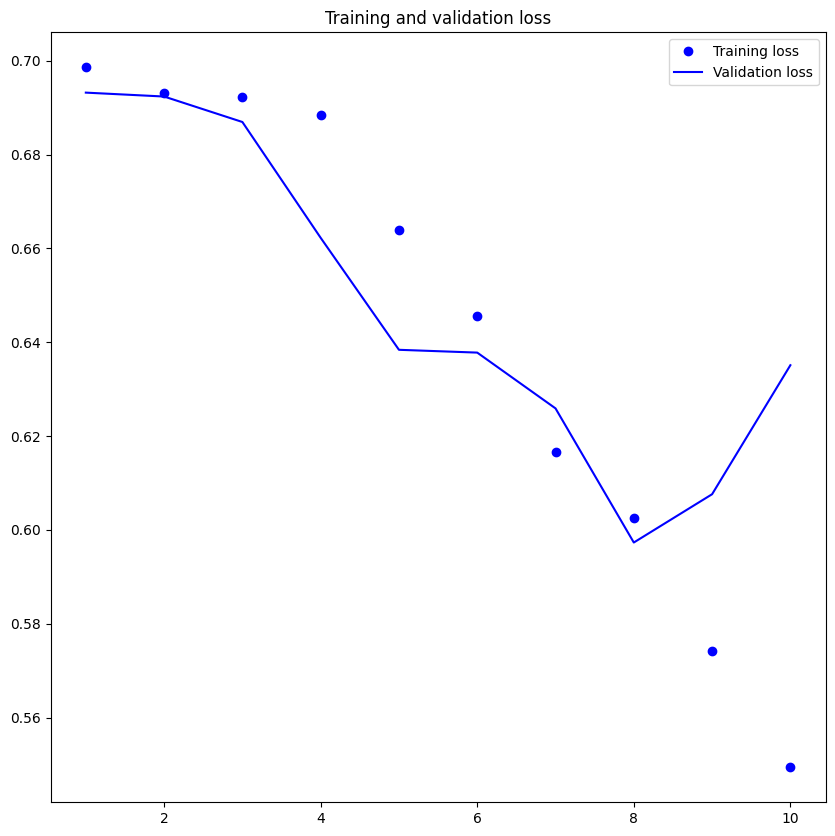

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
test_acc = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_acc.evaluate(testing_df)
print(f"Test accuracy: {test_acc:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6853 - loss: 0.6271
Test accuracy: 0.670


From the above result we can conclude that the test accuracy with no data augmentation is about 69.7% when the Training accuracy is about 92%.

**Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

Using data augmentation

Define a data augmentation stage to add to an image model

In [18]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2167)
make_subset("validation", start_index=2168, end_index=2668)
make_subset("test", start_index=2669, end_index=3168)

In [19]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

showing the training augmented pictures

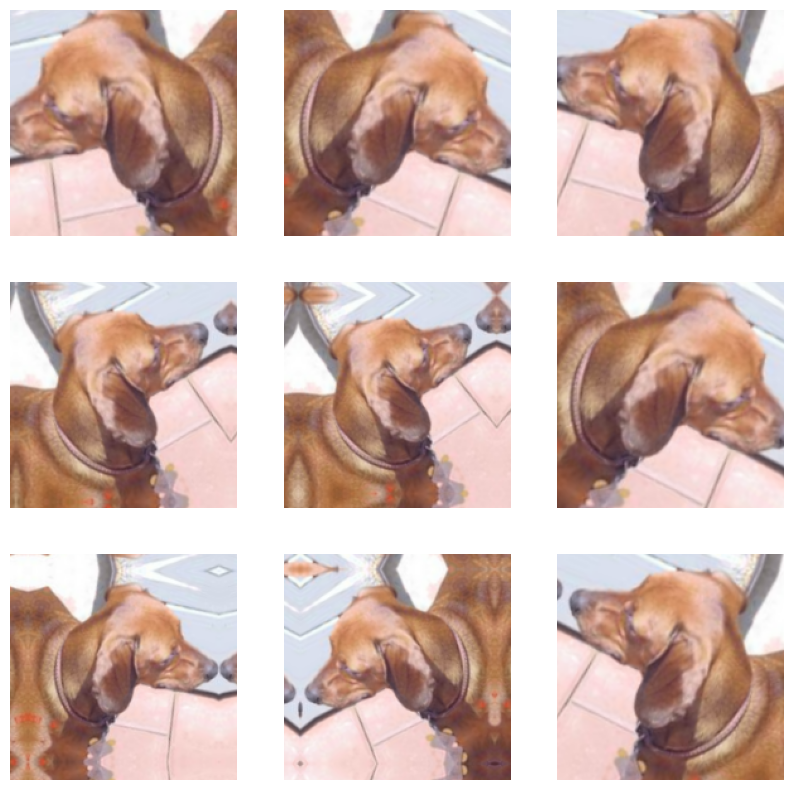

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in training_df.take(1):
    for i in range(9):
        augmented_pics = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_pics[0].numpy().astype("uint8"))
        plt.axis("off")

Creating a new convolutional neural network with dropout and picture augmentation

In [21]:
in2 = keras.Input(shape=(180, 180, 3))
si2 = augmentation(in2)
si2 = layers.Rescaling(1./255)(si2)
si2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(si2)
si2 = layers.MaxPooling2D(pool_size=2)(si2)
si2 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(si2)
si2 = layers.MaxPooling2D(pool_size=2)(si2)
si2 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(si2)
si2 = layers.MaxPooling2D(pool_size=2)(si2)
si2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(si2)
si2 = layers.MaxPooling2D(pool_size=2)(si2)
si2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(si2)
si2 = layers.Flatten()(si2)
si2 = layers.Dropout(0.5)(si2)
op2 = layers.Dense(1, activation="sigmoid")(si2)
model2 = keras.Model(inputs=in2, outputs=op2)

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback_2 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_2 = model2.fit(
    training_df,
    epochs=30,
    validation_data=valid_df,
    callbacks=callback_2)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.5113 - loss: 0.7153 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.4942 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5108 - loss: 0.6935 - val_accuracy: 0.6060 - val_loss: 0.6926
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5170 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4989 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5147 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4959 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5037 - loss: 0.6933 - val_accuracy: 0.5000 - 

model evaluated based on test set

In [23]:
test_acc2 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_acc2.evaluate(testing_df)
print(f"Test accuracy: {test_acc:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5756 - loss: 0.6877
Test accuracy: 0.580


**Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**



Step 3 involved the usage of test sets including 500 samples and 2000 training samples with validation. Compared to training samples of 1000 and 2000 photos, I have found that test accuracy is higher with 1500 images.

When there are 1000 training samples, training accuracy improves.

Raising the training sample to 2000 while maintaining the 500-sample validation and test sets

In [24]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

A new convnet with increased training samples,image augmentation and dropout

In [25]:
in3 = keras.Input(shape=(180, 180, 3))
si3 = augmentation(in3)
si3 = layers.Rescaling(1./255)(si3)
si3 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(si3)
si3 = layers.MaxPooling2D(pool_size=2)(si3)
si3 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(si3)
si3 = layers.MaxPooling2D(pool_size=2)(si3)
si3 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(si3)
si3 = layers.MaxPooling2D(pool_size=2)(si3)
si3 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(si3)
si3 = layers.MaxPooling2D(pool_size=2)(si3)
si3 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(si3)
si3 = layers.Flatten()(si3)
si3 = layers.Dropout(0.5)(si3)
op3 = layers.Dense(1, activation="sigmoid")(si3)
model3 = keras.Model(inputs=in3, outputs=op3)

model3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [26]:
callback_3 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_3 = model3.fit(
    training_df,
    epochs=50,
    validation_data=valid_df,
    callbacks=callback_3)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.5137 - loss: 0.7001 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5230 - loss: 0.6922 - val_accuracy: 0.5660 - val_loss: 0.6913
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5508 - loss: 0.6914 - val_accuracy: 0.5900 - val_loss: 0.6845
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5311 - loss: 0.6900 - val_accuracy: 0.5800 - val_loss: 0.6820
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5694 - loss: 0.6808 - val_accuracy: 0.5100 - val_loss: 0.6857
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5304 - loss: 0.6856 - val_accuracy: 0.6160 - val_loss: 0.6617
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5650 - loss: 0.6706 - val_accuracy: 0.5220 - val_loss: 0.6845
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5671 - loss: 0.6793 - val_accuracy: 0.5720 

In [27]:
acc_testing3 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = acc_testing3.evaluate(testing_df)
print(f"Test accuracy: {test_acc:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7532 - loss: 0.5124
Test accuracy: 0.736


**Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**



Instantiating the VGG16 convolutional base

In [28]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
convolution_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

using a pretrained model for feature extraction without data augmentation

obtaining the labels that correlate with the VGG16 characteristics

In [30]:
import numpy as np

def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return np.concatenate(all_feature), np.concatenate(all_label)

train_features, train_labels =  get_features_and_labels(training_df)
val_features, val_labels =  get_features_and_labels(valid_df)
test_features, test_labels =  get_features_and_labels(testing_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [31]:
train_features.shape

(1000, 5, 5, 512)

In [32]:
in6 = keras.Input(shape=(5, 5, 512))
si6 = layers.Flatten()(in6)
si6 = layers.Dense(256)(si6)
si6 = layers.Dropout(0.5)(si6)
output6 = layers.Dense(1, activation="sigmoid")(si6)
model6 = keras.Model(in6, output6)
model6.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callback_6 = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history_6 = model6.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callback_6)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8450 - loss: 76.7488 - val_accuracy: 0.9600 - val_loss: 3.3024
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9750 - loss: 2.4051 - val_accuracy: 0.9600 - val_loss: 4.8522
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9840 - loss: 1.2558 - val_accuracy: 0.9680 - val_loss: 4.7639
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.5350 - val_accuracy: 0.9580 - val_loss: 4.5901
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9887 - loss: 1.0422 - val_accuracy: 0.9080 - val_loss: 23.2267
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 1.2360 - val_accuracy: 0.9620 - val_loss: 5.8365
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.5860 - val_accuracy: 0.9620 - val_loss: 11.1581
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9914 - loss: 1.0437 - val_accuracy: 0.9660 - val_l

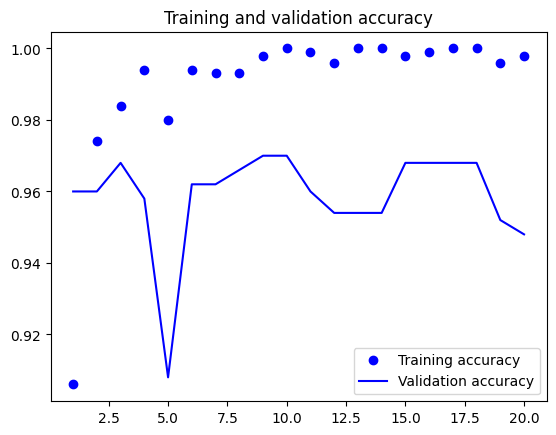

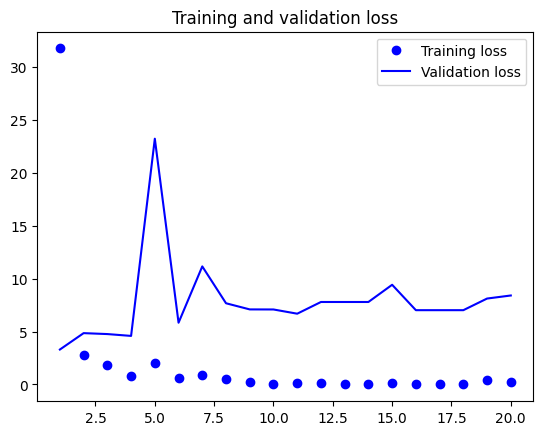

In [33]:
import matplotlib.pyplot as plt
acc6 = history_6.history["accuracy"]
valacc6 = history_6.history["val_accuracy"]
loss6 = history_6.history["loss"]
valloss6 = history_6.history["val_loss"]
epochs = range(1, len(acc6) + 1)
plt.plot(epochs, acc6, "bo", label="Training accuracy")
plt.plot(epochs, valacc6, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss6, "bo", label="Training loss")
plt.plot(epochs, valloss6, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

VGG16 convolutional base instantiation and freezing

In [34]:
convolution_b  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_b.trainable = False

convolution_b.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(convolution_base.trainable_weights))

convolution_b.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 26


Model is now performing with a classifier and agumentation to convulation base

In [35]:
augment2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

in72 = keras.Input(shape=(180, 180, 3))
si7 = augment2(in72)
si7 =keras.layers.Lambda(
     lambda x: keras.applications.vgg16.preprocess_input(x))(si7)
si7 = convolution_base(si7)
si7 = layers.Flatten()(si7)
si7 = layers.Dense(256)(si7)
si7 = layers.Dropout(0.5)(si7)
outputs = layers.Dense(1, activation="sigmoid")(si7)
model = keras.Model(in72, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])




In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    training_df,
    epochs=10,
    validation_data=valid_df,
    callbacks=callbacks
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 530ms/step - accuracy: 0.5366 - loss: 604677.6250 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.5211 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.5131 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.5058 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.4797 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - accuracy: 0.4743 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.4873 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.5281 - loss: 0.6927 - val

Fine-tuning a pretrained model


Freezing all layers until the fourth from the last

In [47]:
convolution_b.trainable = True
for layer in convolution_b.layers[:-4]:
    layer.trainable = False

In [51]:
inputs = keras.Input(shape=(180, 180, 3))
# Replace data_augmentation with augment2. augment2 is the sequential data augmentation layer defined earlier
x = augment2(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = convolution_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_df,
    epochs=30,
    validation_data=valid_df,
    callbacks=callbacks)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 319ms/step - accuracy: 0.5158 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.5099 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.5055 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.5132 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.4953 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.5034 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.4741 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4890 - loss: 0.6932 - val_accuracy:

In [55]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(testing_df)
print(f"Test accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.4921 - loss: 0.6931
Test accuracy: 0.5000
